# **Project 1: Music Recommendations**
a personal project by Nico Ubide

In [ ]:
#Importing packages
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import json
import pandas as pd
import numpy as np
import seaborn as sns
import time
import plotly.graph_objs as go
from plotly.offline import iplot
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image
from IPython.core.display import HTML 
import base64
import requests
import datetime
import matplotlib.pyplot as plt
from urllib.parse import urlencode

## Step 0: Background and Introduction

"Every major streaming service touts its ability to learn your taste and recommend the right song at the right time. And they all use a mix of human curators and computer algorithms to target their suggestions. But increasingly, there is a divide in the industry over which half of that equation should lead and which half should follow" - The Verge

<center> <img src="https://slickdeals.net/blog/wp-content/uploads/2020/06/hero-v4-streaming-services-best-verses-premium.jpg"> </center>

When Apple unveiled its streaming service, Apple Music, in the summer of 2015, it was convinced it would begin to rapidly eat into Spotify’s massive market share based on one core belief: human curation can outperform algorithmic recommendations. In effect, Apple decided to base the majority of its platform on the wisdom and expertise of music PhDs, seasoned radio DJs, and industry experts, in the hopes that it could generate playlists for users that could more accurately capture the emotions and nuances that go into the all important task of choosing your next song. 

Contrastingly, Spotify, which launched in 2006, has always relied on the power of algorithms to make  song recommendations for users, and in the summer of 2015, was faced with the decision to either double down on this bet or to start including more human generated input.

What followed was the launch of Discover Weekly, a hyper-personalised, algorithm-driven playlist for every Spotify user which refreshes every Monday morning, a feature that has since been deemed a resounding success.

So, why did Spotify’s decision to double down on algorithms payoff? It all rests on a key element: **playlists**



---



---




<center><h1><font color='green'><i><b>"The answer was staring us in the face: playlists, since the beginning, have been more or less the basic currency of Spotify. Users have made more than 2 billion of them." </b></i></font>

-- Matt Ogle, Senior Product Owner, Discover Weekly </h1></center>








---

---






In this project, we try to re-create the success that Spotify has achieved with Discover Weekly by leveraging the companies “Million Playlist Dataset” (MPD) to create a music recommender system given an input playlist. Let’s get started

## Step1: Data Wrangling and Engineering

The MPD is structured as 1000 individual JSON files, each of which represents 1000 playlists (1000 playlists * 1000 JSON files = 1,000,000 playlists!). These files were named using the following format: 


*   mpd.slice.0-999.json
*   mpd.slice.1000-1999.json
> ...
*   mpd.slice.999000-999999.json








As a result, the total size of the dataset ends up being a monstrous **32GB**

Here, we print the format of the very first slice (i.e. mpd.slice.0-999.json) for the reader to get a sense of the information stored in each



```
{
    "info": {
        "generated_on": "2017-12-03 08:41:42.057563", 
        "slice": "0-999", 
        "version": "v1"
    }, 
    "playlists": [
        { # Playlist 1
            "name": "Throwbacks", 
            "collaborative": "false", 
            "pid": 0, 
            "modified_at": 1493424000, 
            "num_tracks": 52, 
            "num_albums": 47, 
            "num_followers": 1, 
            "tracks": [
                {
                    "pos": 0, 
                    "artist_name": "Missy Elliott", 
                    "track_uri": "spotify:track:0UaMYEvWZi0ZqiDOoHU3YI", 
                    "artist_uri": "spotify:artist:2wIVse2owClT7go1WT98tk", 
                    "track_name": "Lose Control (feat. Ciara & Fat Man Scoop)", 
                    "album_uri": "spotify:album:6vV5UrXcfyQD1wu4Qo2I9K", 
                    "duration_ms": 226863, 
                    "album_name": "The Cookbook"
                }, 
                {
                    "pos": 1, 
                    "artist_name": "Britney Spears", 
                    "track_uri": "spotify:track:6I9VzXrHxO9rA9A5euc8Ak", 
                    "artist_uri": "spotify:artist:26dSoYclwsYLMAKD3tpOr4", 
                    "track_name": "Toxic", 
                    "album_uri": "spotify:album:0z7pVBGOD7HCIB7S8eLkLI", 
                    "duration_ms": 198800, 
                    "album_name": "In The Zone"
                },

                ... # The rest of the songs in the playlist 1
              
                {
                    "pos": 51, 
                    "artist_name": "Boys Like Girls", 
                    "track_uri": "spotify:track:6GIrIt2M39wEGwjCQjGChX", 
                    "artist_uri": "spotify:artist:0vWCyXMrrvMlCcepuOJaGI", 
                    "track_name": "The Great Escape", 
                    "album_uri": "spotify:album:4WqgusSAgXkrjbXzqdBY68", 
                    "duration_ms": 206520, 
                    "album_name": "Boys Like Girls"
                }
            ], 
            "num_edits": 6, 
            "duration_ms": 11532414, 
            "num_artists": 37
        }, 
        { # Playlist 2
            "name": "Awesome Playlist", 
            "collaborative": "false", 
            "pid": 1, 
            "modified_at": 1506556800, 
            "num_tracks": 39, 
            "num_albums": 23, 
            "num_followers": 1, 
            "tracks":

            ... # The tracks in playlist 2

        }

        ... # Playlists 3 - 1000

    ] #End of playlists

} #End of data
        
```



As we can see, there is **A LOT** of information stored in each slice of 1000 playlists. Each playlist has metadata (e.g. its name, the last time it edited, etc…), data on the tracks in the playlists, and metadata on those tracks (e.g. duration, artist, etc…). Moreover, the data structure is very complex, as it ends up being a series of nested dictionaries - to retrieve the song name of one song in a given playlist, you have to go three dictionaries deep!

Evidently, the magnitude and structure of each slice is what ends up making the complete dataset 32GB in size. This is going to be one of the hardest parts of the project - wrangling the data such that we dramatically reduce its size, without losing any information, and storing it in a data structure that is far easier to work with when it comes time to build our model.


The clearest way to do this is to think about what data we actually want to keep from these original JSON files. That said, what we really only want two things:

1.   Spotify Track ID values
2.   Playlist Names

By just obtaining the Spotify Track ID values, we can later import any and all track audio features (e.g. dancability, acusticness, liveness, tempo, etc...) on an as need basis once we establish a connection to the Spotify web client. Then, if we keep the playlist names as well, we end up with a vector of track IDs with a label attached that (presumably) gives it some kind of semantic meaning.

Unfortunately, Google Collab requires users to re-upload files to storage every time a new runtime connection is established. To avoid having to do this, we run a python script named data_converter.py locally on on all of our JSON files to convert them to 1000 .csv files that are in our desired format. Then, we concatenate all of these .csvs to give us one master file



```
import pandas as pd
import numpy as np
import json

def load_data(slice_):

    lower_bound = (slice_ * 1000) - 1000
    upper_bound = (slice_ * 1000) - 1
    file_path = 'data/mpd.slice.' + str(lower_bound) + '-' + str(upper_bound) + '.json'
    data = json.load(open(file_path, 'r'))
    return data


def playlist_df(data):
    n = len(data["playlists"])

    # Dataframes can't be dynamically resized, so we set the # of rows to
    # the size of the longest playlist +1 to store the playlist name
    df_length = 0
    for i in np.arange(n):
        if len(data["playlists"][i]["tracks"]) > df_length:
            df_length = len(data["playlists"][i]["tracks"])

    # Adding 1 to store the name
    df_length += 1

    # Creating an intial column of df_length zeros
    pl = pd.DataFrame(np.zeros(df_length))

    # Storing each playlist as a column indexed from 0-1
    for i in np.arange(n):
        pl_tracks = [data["playlists"][i]["name"]]
        for song in data["playlists"][i]["tracks"]:
            pl_tracks.append(song["track_uri"].split(":")[-1])
        pl[i] = pd.Series(pl_tracks, name=pl_tracks[0])
    
    return pl


if __name__ == '__main__':
    for i in range(1000, 1001):
        slice_ = load_data(i)
        pl_df = playlist_df(slice_)
        pl_df.to_csv('csv_data/playlist_' + f'{i:04}' + '.csv', index=False)
```



The script took just over 25 minutes to run and reduced the size of our entire data set from 32GB to about **1.8GB!** Now, we have 1000 .csv files that have the following form:


*   playlist_0001.csv
*   playlist_0001.csv
> ...
*   playlist_1000.csv


Each column contains the information we wanted of every playlists. The first row (i.e. index 0) is the name of the playlist. Every subsequent row contains Spotify Track ID information. Finally, once there are no more songs in a given playlist, the rows start filling in with NaN values.

We upload this data to Google Drive so that every time we restart our runtime we simply have to mount our personal drives to Collab in order to access our data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


With our drive mounted and our .csv files uploaded, we can now read in as many playlists as we want using the load_data function below:

In [ ]:
############################Description################################
# Function takes in a number of playlist slices desired to aggregate
# into one dataframe and returns the aggregation. Each slice contains
# 1000 playlists
#######################################################################

def load_data(num_slices):
    #Concatenating 
    all_data = []

    for i in np.arange(1, num_slices+1):
        ext = f'{i:04}'
        slice_ = pd.read_csv('drive/MyDrive/spotify_data/playlist_' + ext + '.csv')
        all_data.append(slice_)

    playlists = pd.concat(all_data, axis=1, ignore_index=True)
    return playlists

We'll start by loading in 100 slices to see how our model performs. If it performs poorly, we can always load in more data later

In [ ]:
#Loading 100,000 playlists
playlists = load_data(100)
playlists.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99960,99961,99962,99963,99964,99965,99966,99967,99968,99969,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99985,99986,99987,99988,99989,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,Throwbacks,Awesome Playlist,korean,mat,90s,Wedding,I Put A Spell On You,2017,BOP,old country,abby,VIBE,relax,sleep,90's,New Songs,slow hands,Mom's playlist,SARAH,melancholy,mixtape,Sad Songs,fall '17,✔️,Twenty one pilots,run it,Winter 2014,smooth,Yeet,groovy,Garage Rock,Running 2.0,acoustic,morning,good good,Good Vibes,indie rock,Hits,tb,Country,...,study,jams,magical,BAElist,Lovey Dovey,#swole,Oldies but Goodies,Chillout,mello,Best Songs of All Time,Morgan,Uplifting,summa '17,Country,cool,Country,workout,Boats n hoes,Streaming,summer 2015,FM,Mama,90s,reggae,MAGCON,Classic Rock,My Music,Favorite,June 2017,August,Day,Jasmine,Champion,reggae vibes,goods,Sauce,LiL Wayne,PHOTOSHOOT,Old School,Rap
1,0UaMYEvWZi0ZqiDOoHU3YI,2HHtWyy5CgaQbC7XSoOb0e,74tqql9zP6JjF5hjkHHUXp,4WJ7UMD4i6DOPzyXU5pZSz,4iCGSi1RonREsPtfEKYj5b,61LtVmmkGr8P9I2tSPvdpf,4SDywo3ykB2PEthjXvo1UP,0GOFjHM4255TjilQwVhauV,2c4QEzLpcIQ6vPRJ26XQqg,6uvT4Di9ZRBw5cbexZJDts,02opp1cycqiFNDpLd2o1J3,1oMVxUgyxXqtCR35sNl8KM,6l9HDwqU46DHCuNyvbmFdP,0zMzyHAeMvwq5CRstru1Fp,0HDaKOlVAfUWXdFR2RhBtN,1FejelrM94Ik1mlI64Ofpb,7w5Ww1cW8U9v8Q3g4qLpVD,0j6YwWZVHsIFKr5FDEu68o,0WgQTMtmw8qJievyeqfnnS,16UCgrePMyBPrtnBaGd4nt,1iDPB2WNsGEWuKycQyDGn6,1LzNfuep1bnAUR9skqdHCK,06u5LrUpbosQlQ1QJFhPpG,5o8OdhjVZSF2wCj7M8UpMN,2Z8WuEywRWYTKe1NybPQEW,5tWMjGYFhWW38gIlyxgste,7Aqu18pKKdYTvtkC5RXCOR,7rR5X9RKz5VprclstYOLb5,1IAzD1muglOxOcPbUHs70R,1wjzFQodRWrPcQ0AnYnvQ9,6v4zAuJTlszNdKrbbnEFu8,5a7NdkF09AfD0H607eiOkX,7BVwi9cIzSc6tpyxsp47vJ,7DqTaelFf846rl1CHmyfOW,18KDpXD6e2UGRA5ORND1CU,6cMswWRv4lAU3mh5lclgCc,2aW9GjctURzw8Yt7BC3wJY,112lQZi5e7i8ohZ4z0e6nu,1hGy2eLcmC8eKx7qr1tOqx,1PoGWZbJPGmViVi7CYbDUK,...,76NHoWRJrfjx0rtF6OZRsM,4Km5HrUvYTaSUfiSGPJeQR,4T9RM96RnC5jAKCYDc2ZDI,5Z3GHaZ6ec9bsiI5BenrbY,5s7sqEQlrcfGMVnyoPn0Qh,5dcYoYFAXh0f0qI05AoufB,7vVIj8Tm1wCawjvwVZdeLD,7rRaAzsnAcZSMGp6KKHckc,3rTnGUeDrnZV22DvRuUuXr,0qi4b1l0eT3jpzeNHeFXDT,2dgFqylK6gyILa4HY65u0y,4SR3SxfHrD8p7m93ObC0LW,6EpRaXYhGOB3fj4V2uDkMJ,1qxINnTuff87Pj1lvKbGxy,3FhuPkzBM6VMLvc6rcer8v,3PwT4UE95RrHyn6pheYS4g,1UZ25gykR30Oewh3dBRtVZ,5cU50IAoAFF7qFWOtdbEjr,1QtiVHiPE7krVMEifmfSJ3,1rVebRMIwmcKeKcEPc29Rw,7ndKzlNlcXK7ffM0Hrp6e5,1jFhnVoJkcB4lf9tT0rSZS,2TYlCPSARkvifu7jvsG1B1,2nCdV3LtOn5jVSGAuyKH7k,7kDmuS9vUMDkn7vLr7VJQG,3Zr81qUZEhR4vPeUFUsBB0,2fPTxlMUIrBnb2qU5Fyabc,1mr3616BzLdhXfJmLmRsO8,2WxVHQkKYr7qUcJBVnJt2E,316r1KLN0bcmpr7TZcMCXT,6PCUP3dWmTjcTtXY02oFdT,24BSTATmWEmrPOgEM17bfN,3bDGwl0X3EjQmIyFD1uif5,5x8JwleWZC1GxZ0tlinZsA,16qYlQ6koFxYVbiJbGHblz,7hDc8b7IXETo14hHIHdnhd,6MreoQf8oixWI2xRcw3Fv1,1AsKenhZTQvnrovrIEm3WO,2zvot9pY2FNl1E94kc4K8M,4uhvMW7ly7tJil31YYscAN
2,6I9VzXrHxO9rA9A5euc8Ak,1MYYt7h6amcrauCOoso3Gx,4erhEGuOGQgjv3p1bccnpn,1Kzxd1kkjaGX4JZz2CYsXB,5qqabIl2vWzo9ApSC317sa,5Q0Nhxo0l2bP3pNjpGJwV1,229SqGbacrLSBfb9XfJczF,3BagxjtKfR4fP85ePlUTDn,1MoDk4XDqdX25GXaRfXY2O,6uvT4Di9ZRBw5cbexZJDts,3ZLyt2ndLFBh148XRYjYYZ,5uIeRAC9O1ZXPQEEqpPVLL,2jyjhRf6DVbMPU5zxagN2h,2zhk0kypGeOPsaaZcjyc14,3jS7bB0oXVOwGFZn3aE5NV,4gCnrdSPvwg38JvfPvjBA3,2TV1CEAFvQiiLhqxUOCQnC,7nqhFb3g7ZtzOEV2QwvyBI,3wtKovRRtvu6wbTjeKA26Q,7bIpR4tyHFgGLkue8fPLjL,0AICBlLzFCTpUqmAbtzB2z,2s4BsyV3KhhrtsdtNfzoqb,6PmnGYDsruYLBNY4Rpx4t9,1FdU4oF88UOJwA9GYgognx,6i0V12jOa3mr6uu4WYhUBr,4gHSezW5CHZCvjAUjF2pd5,7lMwFdaLeJDxiNFd78ScAu,1rUIpUlWtztoo3rVAuSTH4,6mxyfdyF4LD7PctU3UNyjF,5bcTCxgc7xVfSaMV3RuVke,25JD35LDh7CEJ9gKUNruVj,5tf1VVWniHgryyumXyJM7w,7GJClzimvMSghjcrKxuf1M,1E7EDGKKn6I8fzlYQbYlsh,2Mh0jU5IyRTQfpyMnvki5Z,3V0W5CfNDMiTKg93wuLFxJ,3Fx9Xi571ygW3NgX7JbT82,3DGG8PpaMutQSwRX2H2DBc,4fINc8dnfcz7AdhFYVA4i7,6GBUsjHfZuweYf5lQEz6mP,...,1BaOhe084eXesllCBZXHYn,1OAh8uOEOvTDqkKFsKksCi,2WU4ET9r25IVZGQkWOM2UL,5QfQKhvdcxPgp68O0S39FV,4uoyERatKvIr0NlEoe52eS,6w4LIVTA1966CdmIo0yG4x,27m1soUndRthrAA1ediOXn,5mivAtIU

In [ ]:
playlists.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99960,99961,99962,99963,99964,99965,99966,99967,99968,99969,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99985,99986,99987,99988,99989,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that towards the end of all of these playlists we're going to see a bunch of NaN values. This is because the dataframe is as long as its longest playlist. This won't be an issue going forward as we can drop these values when we iterate over individual playlist

## Part 2: EDA

Now that our data is in our desired format, we can begin the EDA portion of the project and producing some visualizations that will help us determine what kind of model we want to build

Part of what we wanted to explore for this project are the average values of audio features of songs in a given playlist (i.e. average tempo, average danceability, average acusticness, etc…) as a way of measuring how similar playlists are to each other


To do that, we must instantiate a connection to the Spotify web client. Here we build a SpotifyAPI class in order to establish this connection. One of the functions of this class will be the “get_resources” function, which will let us obtain audio features based on track ID values


In [ ]:
#Creating client ID and secret - required to access the Spotify web client
client_id = '3b9f6979719c424d9dd84c66963228ad'
client_secret = '454df22536ad48339a75a01eedffc1f8'

In [ ]:
#SpotifyAPI class
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers  
        
    def get_resource(self, lookup_id, resource_type='audio-features', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_audio_features(self, lookup_id, features):
        try:
            values = []
            all_features = self.get_resource(lookup_id)
            values.append([all_features[ft] for ft in features])
            return values[0]
        except:
            return [np.nan] * len(features)

    def get_track_name(self, lookup_id):
        return self.get_resource(lookup_id, resource_type="tracks")["name"]

    def get_track_artist(self, lookup_id):
        return self.get_resource(lookup_id, resource_type="tracks")["artists"][0]['name']

With the class built, we can establish a connection to the Spotify web client

In [ ]:
#Creating an instace of the SpotifyAPI and performing authorization
spotify = SpotifyAPI(client_id, client_secret)
spotify.perform_auth()

True

And here we test the get_resource function to make sure it works the way we want it to - we'll be testing it on the first song of the first playlist of the MPD

In [ ]:
#Testing get_resource to obtain audio features for a given track
spotify.get_resource(playlists[0][1])

{'acousticness': 0.0311,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI',
 'danceability': 0.904,
 'duration_ms': 226864,
 'energy': 0.813,
 'id': '0UaMYEvWZi0ZqiDOoHU3YI',
 'instrumentalness': 0.00697,
 'key': 4,
 'liveness': 0.0471,
 'loudness': -7.105,
 'mode': 0,
 'speechiness': 0.121,
 'tempo': 125.461,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI',
 'type': 'audio_features',
 'uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
 'valence': 0.81}

As we can see, this function will return a wide array of audio feature data - "danceability", "energy", "instrumentalness", "liveness", "loudness", and "speechiness", to name a few.

A potential course of action for our project is to aggregate the values of these audio features for each playlist by taking mean values and then performing clustering techniques to see which playlist are most alike based on audio features. Then, we could recommend to playlist A all of the songs in playlist B that are not already present in playlist A

To do that, we first define a list of audio features we want to pull for each song

In [ ]:
#Desired audio features to extract for each song
desired = ['danceability', 'energy', 'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo']

Next, we define a function named "af_matrix" that will return a vector of the mean values of our desired features for every playlist

In [ ]:
############################Description################################
# Function takes a playlist df and outputs an audio features matrix.
# The matrix contains the mean values of the desired audio features
# we've specified for every playlists
#######################################################################

def af_matrix(pl, desired, pl_percentage):
    #Storing the mean values
    mean_values = []
    #How many playlists do we have
    num_pl = pl.shape[1]
    #Iterating over every playlist
    for i in range(num_pl):
        feature_values = dict()
        num_songs = int(np.round(len(pl[i][1:].dropna())*pl_percentage))
        #Iterating over every song * percentage
        for j in range(1, num_songs+1):
            feature_values[j] = spotify.get_audio_features(pl[i][j], desired)
        #Appending mean audio features for playlist i
        mean_values.append(pd.Series(pd.DataFrame(feature_values, index=desired).apply(np.mean, axis=1), name=i))
    #Creating the dataframe of mean values
    return pd.DataFrame(mean_values).T

To test it out, we run the function on a subset of our "playlists" df that only includes the first 5 playlists

In [ ]:
#Testing af_matrix
af_matrix(playlists.iloc[:,:5], desired, 1)

,0,1,2,3,4
danceability,0.664058,0.492459,0.671813,0.494621,0.576294
energy,0.781077,0.695949,0.693250,0.635978,0.650476
speechiness,0.103679,0.091003,0.096280,0.068559,0.041200
acousticness,0.083693,0.162225,0.268866,0.272612,0.177130
instrumentalness,0.000674,0.223710,0.000638,0.218011,0.081758
liveness,0.187087,0.179364,0.169033,0.177401,0.166524
valence,0.642769,0.476769,0.565000,0.461537,0.490529
tempo,121.157538,124.985231,114.601094,124.137149,127.725471


Looks like it works!

However, our runtime is really slow (~2-4 seconds per playlist). What’s more, sometimes the function will return all NaN values for some of the playlist. This occurs because, in some instances, when we run the track ID through the get_resource function, it returns all NaN values - in other instances, it returns the audio features we were looking for. That said, we've verified that all of our ID values are in fact legitimate, so we're not sure what the issue could be. Nevertheless, we’ve spot checked the mean values returned for some of the other playlists and found that they were all accurate.

Given these two issues, we’ll proceed by calculating the audio features matrix on 1000 playlists (which should take ~35 minutes), and we’ll drop all the resulting NaN columns. This should still leave us with a considerable number of playlists to train our model on

In [ ]:
#Selecting 1000 columns and dropping the resulting columns that have all NaN values
playlists_af = af_matrix(playlists.iloc[:,:1000], desired, 1)
playlists_af.dropna(axis=1, inplace=True)

In [ ]:
#Visualizing
playlists_af

,0,1,2,3,4,5,6,7,8,10,11,14,15,16,17,18,19,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,...,950,951,952,953,955,956,960,961,962,963,964,965,966,967,968,971,972,974,976,977,978,979,980,981,982,983,984,985,986,987,988,989,992,993,994,995,996,997,998,999
danceability,0.664058,0.492459,6.871111e-01,0.520619,0.348333,0.672571,0.504750,0.647113,0.483391,0.724074,0.631926,0.520426,0.671286,0.524108,0.557542,0.609191,0.521500,0.656952,0.414400,0.622286,0.703878,0.518429,0.9000,0.577000,0.712903,0.422562,0.675069,0.563933,0.5810,0.599000,0.662174,0.395000,0.525,0.644200,0.554086,0.635650,0.537842,0.6270,5.080000e-01,0.601788,...,0.618260,0.542111,0.811300,0.644969,0.616337,0.296696,0.68460,0.555385,0.557350,0.516700,0.666833,0.838000,0.600111,0.661455,0.566737,0.877286,0.636560,0.665100,0.58220,0.654450,0.73650,0.611745,0.701462,0.520657,0.691884,0.69020,0.673337,0.672500,0.649000,0.524508,0.560714,0.543600,0.577333,0.638342,0.582803,0.651750,0.886,0.74800,0.568683,0.541773
energy,0.781077,0.695949,6.846667e-01,0.620004,0.738333,0.807357,0.779625,0.576245,0.740130,0.647222,0.601148,0.736508,0.468286,0.724297,0.830500,0.626044,0.362833,0.649381,0.933850,0.629714,0.799561,0.584000,0.5380,0.691500,0.656194,0.705064,0.769431,0.446931,0.5380,0.668611,0.728928,0.747000,0.433,0.599200,0.807862,0.594537,0.668624,0.7030,8.985000e-01,0.670970,...,0.714000,0.773556,0.622100,0.606813,0.668250,0.217940,0.62080,0.551923,0.763050,0.770500,0.606167,0.765000,0.842667,0.768000,0.851188,0.585000,0.556530,0.758600,0.56480,0.695080,0.57250,0.761798,0.711231,0.411257,0.656698,0.74760,0.676899,0.618250,0.753000,0.812873,0.595071,0.363820,0.469667,0.570318,0.608461,0.643750,0.525,0.66350,0.663951,0.334227
speechiness,0.103679,0.091003,9.294444e-02,0.067000,0.037600,0.065021,0.046812,0.076032,0.050335,0.156007,0.077541,0.042680,0.056929,0.045262,0.059396,0.073922,0.035775,0.074733,0.080130,0.124586,0.104768,0.068929,0.0343,0.201850,0.107390,0.056560,0.070159,0.041418,0.0309,0.076531,0.067162,0.032900,0.185,0.065580,0.049431,0.110983,0.034761,0.2360,5.405000e-02,0.055164,...,0.069014,0.083056,0.164420,0.047875,0.042154,0.044921,0.03872,0.073846,0.040803,0.103780,0.172767,0.280000,0.056189,0.097182,0.057050,0.261029,0.079960,0.085220,0.12000,0.124212,0.17300,0.063219,0.148873,0.035371,0.146486,0.23074,0.207284,0.118463,0.031900,0.060522,0.061029,0.034500,0.037467,0.147042,0.156956,0.075000,0.131,0.27845,0.038583,0.068025
acousticness,0.083693,0.162225,2.721222e-01,0.274545,0.057505,0.045038,0.063970,0.318786,0.172319,0.174252,0.215168,0.060774,0.532857,0.164109,0.099441,0.181627,0.572475,0.098539,0.001594,0.152679,0.114434,0.267136,0.2290,0.041950,0.139981,0.254066,0.107074,0.554144,0.8240,0.222595,0.084060,0.105000,0.107,0.156802,0.146646,0.240393,0.201912,0.5630,4.460000e-03,0.260791,...,0.088621,0.031758,0.064612,0.278304,0.236125,0.793250,0.17706,0.386869,0.137320,0.018953,0.064983,0.028300,0.138171,0.276073,0.059444,0.135886,0.254770,0.028344,0.28841,0.121544,0.15175,0.107703,0.105601,0.589914,0.208728,0.11612,0.115292,0.125266,0.020900,0.041328,0.221918,0.566740,0.189400,0.298059,0.297464,0.113050,0.236,0.01341,0.234450,0.614511
instrumentalness,0.000674,0.223710,1.866667e-07,0.185935,0.250333,0.001463,0.037789,0.076220,0.086288,0.000222,0.266680,0.043064,0.058661,0.191031,0.003028,0.013899,0.205840,0.020143,0.040043,0.000007,0.113641,0.050157,0.8430,0.000009,0.004363,0.408867,0.036591,0.007086,0.1360,0.021712,0.001092,0.000245,0.000,0.000468,0.000074,0.004029,0.003590,0.0000,8.250000e-07,0.000401,...,0.003966,0.038219,0.001231,0.012440,0.015302,0.609656,0.65670,0.002286,0.001560,0.306880,0.000001,0.000015,0.061711,0.000310,0.004734,0.000000,0.009369,0.290814,0.02147,0.007014,0.00000,0.007677,0.016324,0.003754,0.020659,0.00000,0.009181,0.000503,0.000058,0.014761,0.003322,0.002829,0.000000,0.041337,0.105907,0.000198,0.000,0.00088,0.000367,0.044998
liveness,0.187087,0.179364,1.061778e-01,0.191805,0.215667,0.216236,0.222500,0.123825,0.

Now, we can create some visualizations, starting with a Wordcloud of the playlist names

Wordclouds are visualizations that represent the distribution of words within a group. The more occurrences of a word, the larger it will be, and vice versa. In this scenario, we can take the top 40 words (in order to avoid clutter) used in playlist titles. To do so, we'll transpose the data to create a column of playlist titles and then create a wordcloud based on a long string of these titles. 

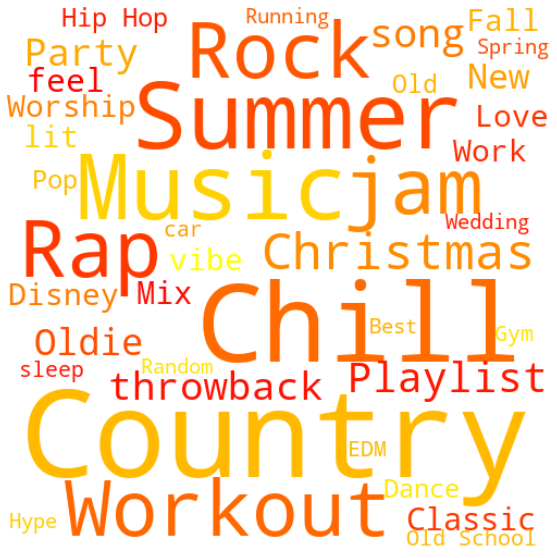

In [ ]:
#Storing playlist names and generating Wordcloud
playlist_names = list(playlists.iloc[0][:].astype(str))
wordcloud = WordCloud(width=500, height=500, margin=0, background_color='white', colormap= 'autumn', max_words=40).generate(' '.join(playlist_names))

#Graphing
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Above we can see the top 40 words used in titles within our data slice of 100,000 playlists. This graphic helps us to get an idea of the kinds of playlists we're working with. It appears the two most prominent words are 'Country' and 'Chill' with close followers 'Workout', 'Rap', 'Jam', 'Music', and 'Summer'.

Another visualization we want to make is a density plot using Seaborn to see how our audio features are distributed.

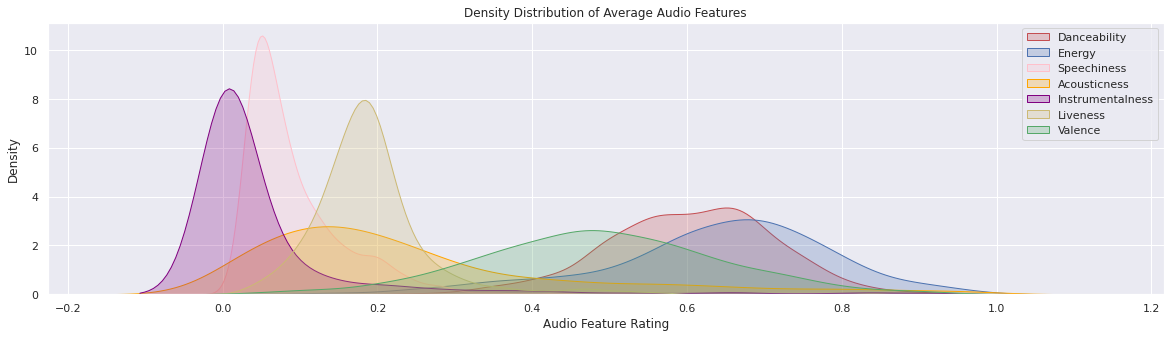

In [ ]:
#Creating the density plot with shade
p1=sns.kdeplot(playlists_af.loc["danceability"], shade=True, bw_method=.25, color="r", legend=True)
p2=sns.kdeplot(playlists_af.loc["energy"], shade=True, bw_method=.25, color="b", legend=True)
p3=sns.kdeplot(playlists_af.loc["speechiness"], shade=True, bw_method=.25, color="pink", legend=True)
p4=sns.kdeplot(playlists_af.loc["acousticness"], shade=True, bw_method=.25, color="orange", legend=True)
p5=sns.kdeplot(playlists_af.loc["instrumentalness"], shade=True, bw_method=.25, color="purple", legend=True)
p6=sns.kdeplot(playlists_af.loc["liveness"], shade=True, bw_method=.25, color="y", legend=True)
p7=sns.kdeplot(playlists_af.loc["valence"], shade=True, bw_method=.25, color="g", legend=True)

#Graphing
sns.set(rc={'figure.figsize':(10,5)})
plt.title('Density Distribution of Average Audio Features')
plt.xlabel('Audio Feature Rating')
plt.legend(labels=['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence'])
plt.show()

Here we can see a general overview of the audio features in our data set. It appears that "instrumentalness" and "speechiness" levels are heavily weighted towards zero and "liveness" is consistently low as well. "Energy" and "danceability" are at high levels above 0.5 quite often. "Valence" and "acousticness" seem to be more evenly distributed. 

Finally, we want to calculate the correlations between any two audio features in our data and plot the pairwise correlations using Seaborn's pairplot

In [ ]:
#Calculating correlations between features
playlists_af.T.corr()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1.000000,0.243826,0.442639,-0.356599,-0.226032,-0.136006,0.412050,-0.113310
energy,0.243826,1.000000,0.107209,-0.816627,-0.191807,0.168441,0.412214,0.192774
speechiness,0.442639,0.107209,1.000000,-0.214949,-0.177951,0.075501,0.060571,0.032303
acousticness,-0.356599,-0.816627,-0.214949,1.000000,0.250594,-0.044369,-0.252518,-0.169675
instrumentalness,-0.226032,-0.191807,-0.177951,0.250594,1.000000,-0.053560,-0.230595,-0.113650
liveness,-0.136006,0.168441,0.075501,-0.044369,-0.053560,1.000000,0.047582,0.104702
valence,0.412050,0.412214,0.060571,-0.252518,-0.230595,0.047582,1.000000,0.017324
tempo,-0.113310,0.192774,0.032303,-0.169675,-0.113650,0.104702,0.017324,1.000000


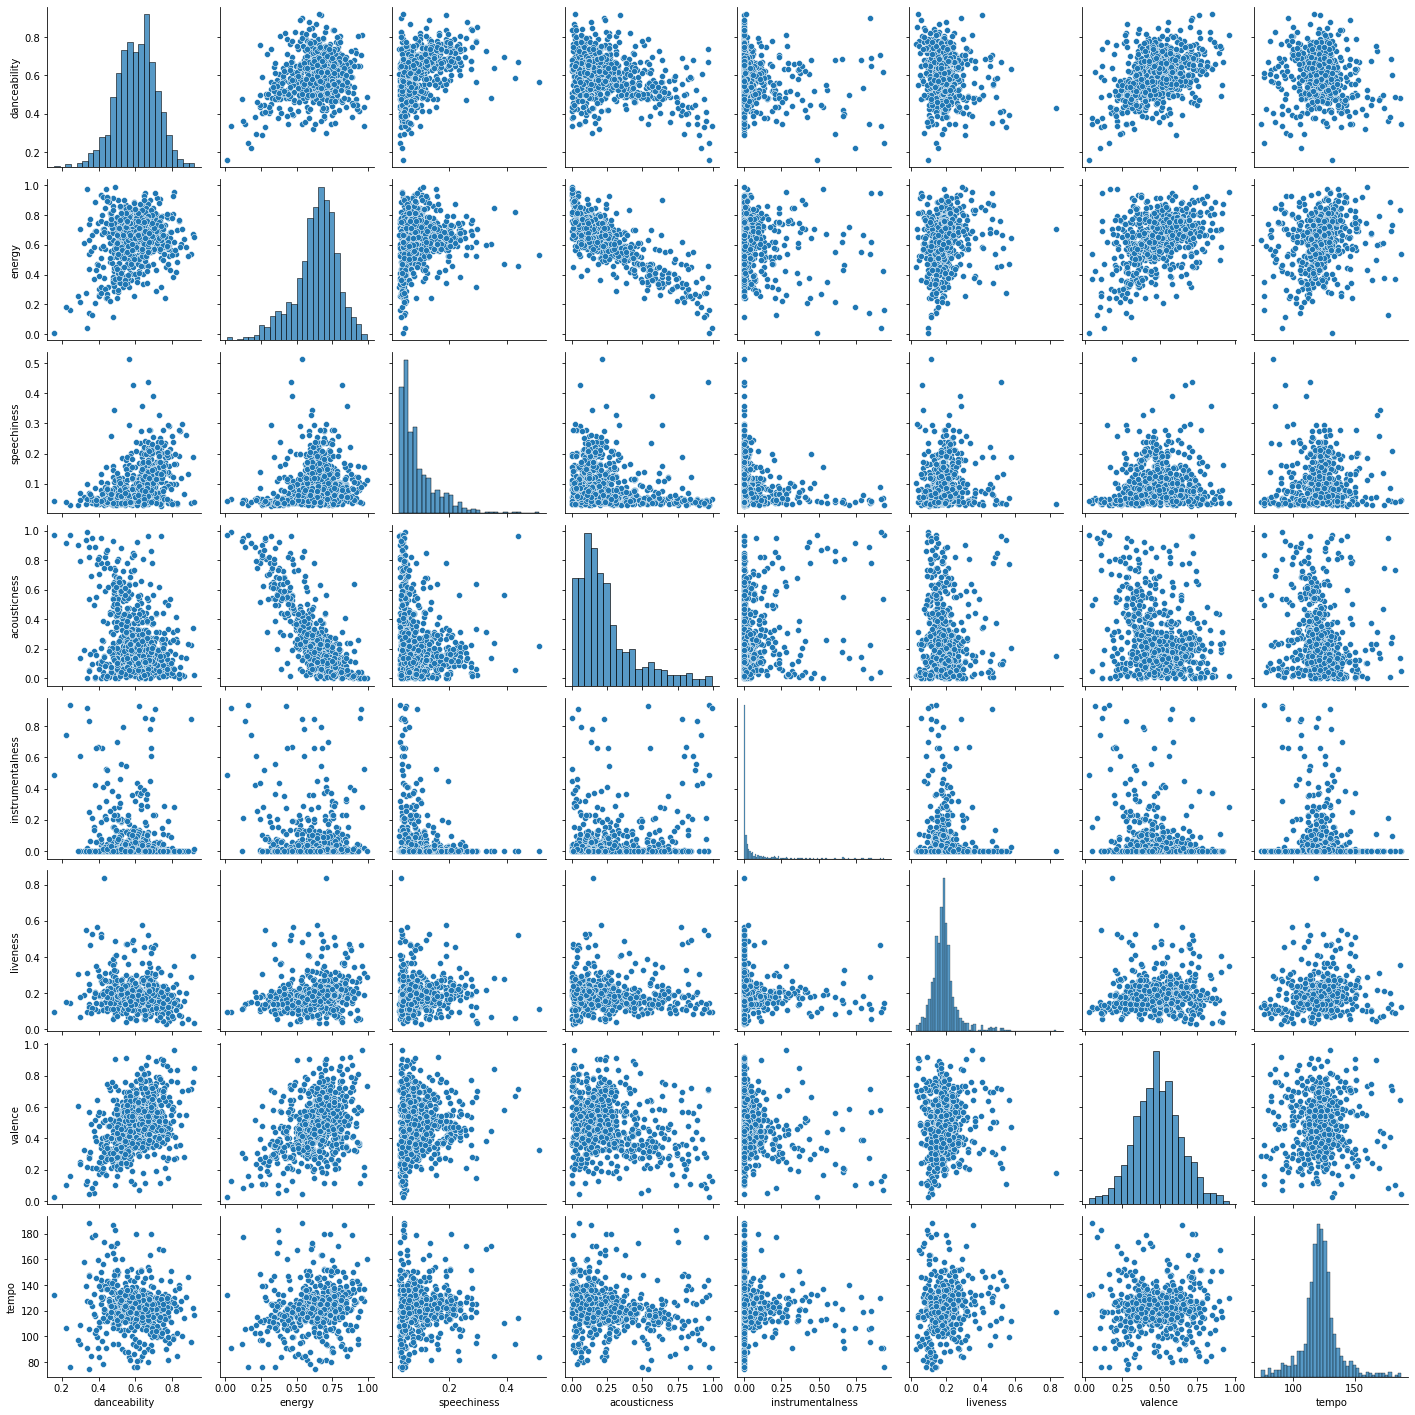

In [ ]:
#Generating pairwise scatterplots
sns.pairplot(playlists_af.T)
plt.show()

Some standout correlations include the moderate ones observed between danceability and valence, energy and valence, speechiness and danceability, and the (obviously) large negative correlation between energy and acousticness.

That said, these moderate correlations are something we can take care of in the future through PCA

In [ ]:
playlists_af = pd.read_csv('playlists_af_matrix.csv', index_col=0)

In [ ]:
playlists_af.columns = playlists_af.columns.astype(int)

## Part 3: Models

### Model 1: Audio Feature Clustering

The first model we want to test involves clustering our playlists based on how similar their mean audio feature values are and recommending songs that appear with the highest frequency in each cluster. We'll train the model on ~75% of our data by taking the 750 playlist audio features we produced above and clustering them. Then, we'll test the model by using the algorithm we've trained to assign labels to 250 other playlists based on the audio features of **50%** of the songs they contain. We do this because, once the algorithm has classified each playlist based on half of its songs, we want to check the recommendations it outputs by finding how many recommendations are present in the "hidden" 50% of songs for each playlist. This will give us an accuracy score for our model.

Evidently, our choice of how many clusters to have will be key. We want the number of clusters to be high enough that the recommendations are tailored to unique audio feature combinations but we also don't want the number of clusters to be so high that we end up with some clusters that only have 1 playlist, as these won't be able to recieve recommendations

Let's dive into it - first, we split the data into training and testing. Again, the training data will contain mean playlist features generated from **all** songs. The testing data will contain mean playlist features generated from **50%** of songs.

In [ ]:
#Manual ~75/25 split:

#Assigning training data from df produced above
pl_af_train = playlists_af

#Generating testing data
playlists_af_test = playlists.iloc[:,1000:1250]
playlists_af_test.columns = range(0, 250)
pl_af_test = af_matrix(playlists_af_test, desired, 0.5)
pl_af_test.dropna(axis=1, inplace=True)

In [ ]:
print("Training data contains: " + str(pl_af_train.shape[1]) + " playlists")
print("Testing data contains: " + str(pl_af_test.shape[1]) + " playlists")

Training data contains: 748 playlists
Testing data contains: 233 playlists


Now, we standardize/normalize our data (as PCA is not scale invariant) and reduce our dimensionality using PCA. We'll output a graph that shows us the cumulative explained variance by component in order to decide how many components to keep

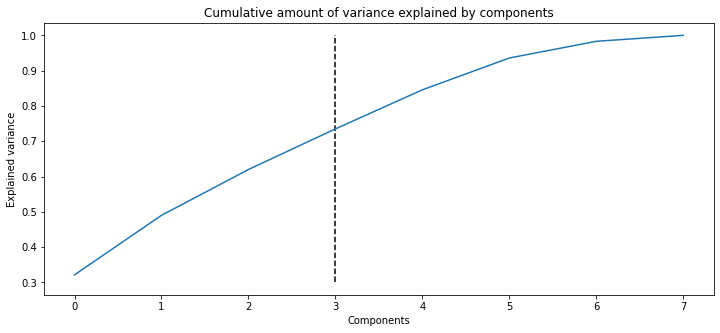

In [ ]:
#Standardizing the features based on unit variance
train_scaled = StandardScaler().fit_transform(pl_af_train.T)
test_scaled = StandardScaler().fit_transform(pl_af_test.T)

#Creating PCA and determining how many components to keep
pca = PCA().fit(train_scaled)
variance = np.cumsum(pca.explained_variance_ratio_)

#Plotting the explained variance
plt.figure(figsize=(12, 5))
plt.plot(variance)
plt.vlines(x=3, ymin=0.3, ymax=1.0, color='black', linestyles='dashed')
plt.title('Cumulative amount of variance explained by components')
plt.xlabel('Components')
plt.ylabel('Explained variance')
plt.show()

It looks like with 3 components we get over 70% of our explained variance, so we'll keep 3

In [ ]:
#Creating PCA, keeping 3 components, and embedding train and test sets
pca = PCA(n_components=3)
train_scaled_embedded = pca.fit_transform(train_scaled)
test_scaled_embedded = pca.transform(test_scaled)

Now, we want to fit a KMeans algorithm to our training set, predict labels for our testing set, and obtain the accuracy of the recommendations we output. What's more, we want to do this with many different K-Values to see which one is most accurate. To do this, we use the function below which works as follows:



1. Generate KMeans algorith with k = 2 and fit it to our training set
2. Predict labels for our testing set
3. Use the "get_recs" function to generate recommendations for every predicted cluster in our testing set. "Get_recs" takes in a cluster value (e.g. 1, 2, ..., k) and finds the frequency with which every song in that cluster appears. Then, it returns the top (num_recs) most frequent songs as the song recommendations
4. Use the "get_hidden_tracks" function to obtain the 50% of tracks **we didn't use**  to generate the mean audio features of our testing set (i.e. the KMeans algorithm has never seen this data)
5. Calculate the accuracy by seeing the percentage of recommendations that are present in the hidden 50% of tracks
6. Repeat steps 1-5 for k = 3, 4,....













In [ ]:
def af_accuracy(train_embedded, test_embedded, k_val):

    #Creating n/10 clusters for the KMeans algorithm
    km = KMeans(k_val, 'random', n_init=1, max_iter=300, random_state=0, algorithm='auto').fit(train_embedded)

    #Make predictions on testing set
    test_pred = km.predict(test_embedded)

    #Aggregating
    clusters_df = pd.DataFrame({"playlist": pl_af_train.columns, "cluster": km.labels_})

    #Using cluster data to name columns for easy indexing
    train_clustered = playlists[list(pl_af_train.columns)]
    train_clustered.columns = list(clusters_df["cluster"].values)

    #Assigning labels for testing set
    test_clustered = playlists[list(pl_af_test.columns)]
    test_clustered.columns = list(test_pred)

    def get_recs(data, cluster, num_recs=None):
        unique, counts = np.unique(data[cluster][1:].astype(str), return_counts=True)
        frequencies = np.asarray((unique, counts)).T
        if num_recs == None:
            return list(pd.DataFrame(frequencies).sort_values(by=[1], ascending=False)[0][1:])
        else:
            return list(pd.DataFrame(frequencies).sort_values(by=[1], ascending=False)[0][1:num_recs+1])

    def get_hidden_tracks(pl, pl_percentage):
        hidden = []
        num_songs = len(pl[1:].dropna())
        half_songs = int(np.round(num_songs*pl_percentage))
        for i in range(half_songs, num_songs+1):
            hidden.append(pl[i])
        return hidden

    #Storing accuracies
    accuracies = []

    def accuracy(pl):
        cluster = pl.name
        hidden_songs = get_hidden_tracks(pl, 0.5)
        recs = get_recs(test_clustered, cluster, 10)
        correct = sum(song in recs for song in hidden_songs)
        if correct == 0:
            return 0
        else:
            return correct / len(recs)

    #Calculating
    for i in range(test_clustered.shape[1]):
        accuracies.append(accuracy(test_clustered.iloc[:,i]))

    #Ouputting mean
    return np.mean(accuracies), km.inertia_

With our "af_accuracy" function defined, we now run it from k=2 clusters to k=n clusters in increments of 10, where (n) is the total number of playlists we have in our training set

In [ ]:
#Storing accuracies and distortions
accuracies = []
distortions = []

#Iterating from k=2 to k=(n) in steps of 10
for i in range(1,748, 10):
    acc, dist = af_accuracy(train_scaled_embedded, test_scaled_embedded, i)
    accuracies.append(acc)
    distortions.append(dist)

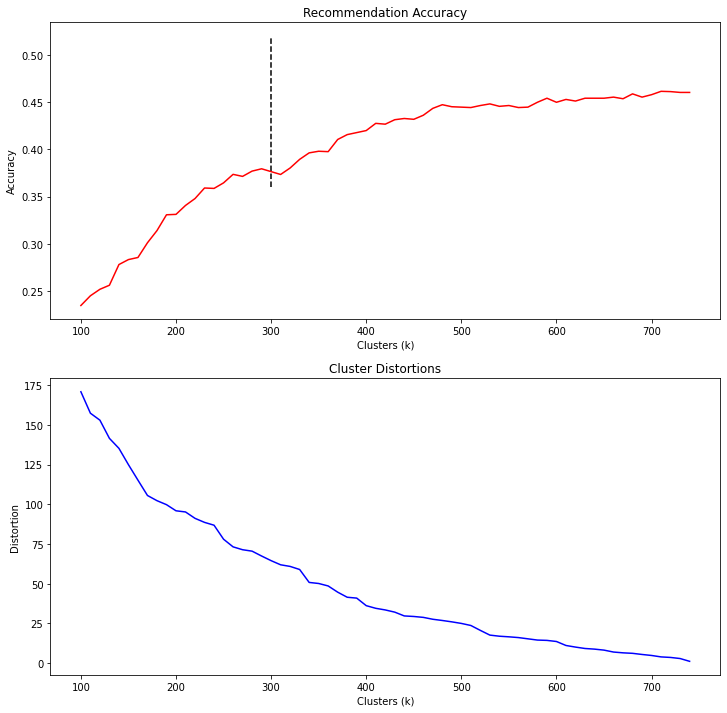

In [ ]:
#Graphing
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax0, ax1, = axes.flatten()

ax0.plot(range(100,748, 10), accuracies[10:], color="red")
ax0.vlines(x=300, ymin=0.360, ymax=0.520, color='black', linestyles='dashed')
ax0.set_title('Recommendation Accuracy')
ax0.set_xlabel('Clusters (k)')
ax0.set_ylabel('Accuracy')

ax1.plot(range(100,748, 10), distortions[10:], color="blue")
ax1.set_title('Cluster Distortions')
ax1.set_xlabel('Clusters (k)')
ax1.set_ylabel('Distortion')

plt.show()

It looks like the best we can do is an accuracy of just above 50%, a threshold we cross once the number of clusters we have exceeds 300

To recap, what we've done here is as follows:

- Found the mean values for audio features for acusticness, livesness, valence, etc... for 748 playlists
- Reduced the dimensionality from 8 to 3 using PCA, as the first 3 components account for over 70% of the variability in the data
- Trained a KMeans algorithim using this meaned playlist feature data, with (k) values varying from 2 - 748 in increments of 10
- Using this algorithm, we predicted labels for a testing set that contained the meaned audio features of only 50% the songs in the playlists
- Took the 10 highest frequency tracks present in each cluster and recomended those as the extension of the playlist in question
- Compared those recommendations to the other 50% of the songs that we didn't include in the audio feature meaning process
- Record how many of our 10 recommendations were present in the leftover 50% of songs


To get a better sense of our result, we want to graph the three largest clusters our KMeans algorithm generates when we set k = 300 for both our training data and our testing data

In [ ]:
#Creating 300 clusters as per our accuracy and distortion results
km = KMeans(300, 'random', n_init=1, max_iter=300, random_state=42, algorithm='auto').fit(train_scaled_embedded)
test_pred = km.predict(test_scaled_embedded)

In [ ]:
#Finding the three largest clusters for training data
unique, counts = np.unique(km.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
largest_clusters_train = pd.DataFrame(frequencies).sort_values(by=[1], ascending=False).head(3)
largest_clusters_train

,0,1
130,130,10
57,57,7
80,80,6


Now, we do the same for the testing set

In [ ]:
#Finding the three largest clusters for testing data
unique, counts = np.unique(test_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T
largest_clusters_test = pd.DataFrame(frequencies).sort_values(by=[1], ascending=False).head(3)
largest_clusters_test

,0,1
19,90,3
25,109,3
48,215,3


In [ ]:
#Storing biggest clusters
biggest_labels_train = list(largest_clusters_train[0])
biggest_labels_test = list(largest_clusters_test[0])

In [ ]:
#Creating the clusters to graph
clust0_train = np.array([x for i, x in enumerate(train_scaled_embedded) if km.labels_[i] == biggest_labels_train[0]])
clust0_test = np.array([x for i, x in enumerate(test_scaled_embedded) if test_pred[i] == biggest_labels_test[0]])

clust1_train = np.array([x for i, x in enumerate(train_scaled_embedded) if km.labels_[i] == biggest_labels_train[1]])
clust1_test = np.array([x for i, x in enumerate(test_scaled_embedded) if test_pred[i] == biggest_labels_test[1]])

clust2_train = np.array([x for i, x in enumerate(train_scaled_embedded) if km.labels_[i] == biggest_labels_train[2]])
clust2_test = np.array([x for i, x in enumerate(test_scaled_embedded) if test_pred[i] == biggest_labels_test[2]])

other_train = np.array([x for i, x in enumerate(train_scaled_embedded) if km.labels_[i] not in biggest_labels_train])
other_test = np.array([x for i, x in enumerate(test_scaled_embedded) if test_pred[i] not in biggest_labels_test])

In [ ]:
######################### TRAINING DATA ###############################

#Graphing:
cluster_1_train = go.Scatter3d(
    x = clust0_train.reshape(3, clust0_train.shape[0])[0],
    y = clust0_train.reshape(3, clust0_train.shape[0])[1],
    z = clust0_train.reshape(3, clust0_train.shape[0])[2],
    mode = 'markers',
    name = 'Cluster 1',
   )
cluster_2_train = go.Scatter3d(
    x = clust1_train.reshape(3, clust1_train.shape[0])[0],
    y = clust1_train.reshape(3, clust1_train.shape[0])[1],
    z = clust1_train.reshape(3, clust1_train.shape[0])[2],
    mode = 'markers',
    name = 'Cluster 2',
   )
cluster_3_train = go.Scatter3d(
    x = clust2_train.reshape(3, clust2_train.shape[0])[0],
    y = clust2_train.reshape(3, clust2_train.shape[0])[1],
    z = clust2_train.reshape(3, clust2_train.shape[0])[2],
    mode = 'markers',
    name = 'Cluster 3',
   )
other_data_train = go.Scatter3d(
    x = other_train.reshape(3, other_train.shape[0])[0],
    y = other_train.reshape(3, other_train.shape[0])[1],
    z = other_train.reshape(3, other_train.shape[0])[2],
    mode = 'markers',
    name = 'Rest of data',
    opacity = 0.05,
   )
#Graphing training data
layout = go.Layout(title = '3 Largest K-Means Clusters of Meaned Playlist Audio Features in Testing Set')
fig1 = go.Figure(data = [cluster_1_train, cluster_2_train, cluster_3_train, other_data_train],
                layout = layout,)
iplot(fig1)

######################### TESTING DATA ###############################

#Graphing:
cluster_1_test = go.Scatter3d(
    x = clust0_test.reshape(3, clust0_test.shape[0])[0],
    y = clust0_test.reshape(3, clust0_test.shape[0])[1],
    z = clust0_test.reshape(3, clust0_test.shape[0])[2],
    mode = 'markers',
    name = 'Cluster 1',
   )
cluster_2_test = go.Scatter3d(
    x = clust1_test.reshape(3, clust1_test.shape[0])[0],
    y = clust1_test.reshape(3, clust1_test.shape[0])[1],
    z = clust1_test.reshape(3, clust1_test.shape[0])[2],
    mode = 'markers',
    name = 'Cluster 2',
   )
cluster_3_test = go.Scatter3d(
    x = clust2_test.reshape(3, clust2_test.shape[0])[0],
    y = clust2_test.reshape(3, clust2_test.shape[0])[1],
    z = clust2_test.reshape(3, clust2_test.shape[0])[2],
    mode = 'markers',
    name = 'Cluster 3',
   )
other_data_test = go.Scatter3d(
    x = other_test.reshape(3, other_test.shape[0])[0],
    y = other_test.reshape(3, other_test.shape[0])[1],
    z = other_test.reshape(3, other_test.shape[0])[2],
    mode = 'markers',
    name = 'Rest of data',
    opacity = 0.05,
   )
#Graphing testing data
layout = go.Layout(title = '3 Largest K-Means Clusters of Meaned Playlist Audio Features in Training Set')
fig2 = go.Figure(data = [cluster_1_test, cluster_2_test, cluster_3_test, other_data_test],
                layout = layout,)
iplot(fig2)

These visualizations are very interesting. When we look at the clusters of our training set, it appears are algorithm was able to cluster playlists that were very similar in all three of their principal components (e.g. the red and blue clusters) **and** playlists that had considerable variation in their principal components (e.g. the green clusters). Our best prediction as to what is happening here is that the algorithm is clustering some playlists that are similar because they are “genre” or “artist” playlists (e.g. playlists that have exclusively rap songs or songs by Guns N’ Roses together) as these will have pretty consistent audio features across songs **and** its clustering playlists that are “random” or "situational" and have very different audio features across songs. Examples of these “random” playlists could be a “car” playlist or “2017 hits” playlist - there is no reason for the songs to be similar in features but they often appear together in playlists due to the semantic meaning attached to them by users.

If this is in fact what our algorithm is detecting, our results are pretty remarkable, as the clustering technique is successfully finding some innate structure in this data where we wouldn’t expect there to be any.

When we look at the clusters of our testing set, we see that the same is occurring. The red and green cluster is seem to group playlists with similar PCA components and the blue cluster seems to cut across components.

### Model 2: PageRank Reimagined

Our analysis of audio features showed that there are some playlists that are similar because they have audio features that are similar (which was expected) but it also showed that there are playlists that can be deemed similar even with audio features that are very different. We posited that this was because the algorithm was picking up on “genre” or “artist” playlists, that typically have similar features across songs, and “random” or “situational” playlists, that typically vary in their audio features throughout.

Given this conclusion, we now want to try implementing an interpretation of Google’s PageRank algorithm to recommend songs, which we call: <mark> **SongRank**</mark>. The idea is simple, say I have a playlist of 10 songs. First I want to take song #1 - say, Sweet Child O’ Mine by Guns N’ Roses - and check all of the other playlists it is present in. Then, I want to record all of the **other** songs present in those playlists that also contain Sweet Child O’ Mine. This gives me a long list of songs that all appeared in playlists that Sweet Child O’ Mine was also in (with duplicates included). Finally, I want to check the frequency with which these other songs appear in my list and sort then in descending order. The top song of this list will be the song that appears the highest number of times in playlists that contain Sweet Child O’ Mine. Moreover, we can consider the frequency with which these other songs show up as “votes”, the same way PageRank does.

After doing this for song #1, I want to do this for every song in my playlist and aggregate the votes the these “other songs” are receiving. The top 5 songs will be the most “voted” other songs and will be the songs that appear the most frequently in playlists that contain the songs that are currently in my own playlist.

We believe this will be an effective algorithm to use because it build on our conclusions from Model 1. SongRank should be able to pick up on both the innate structure present in playlists but also the imposed structure created by human users.

What’s more, this model should outperform model 1 as it will be generating recommendations that are personalized to every playlist as opposed to every “cluster” of playlists.

In [ ]:
#We'll use this ID as a tester for now
id_ = '0UaMYEvWZi0ZqiDOoHU3YI'

The first thing we'll create is a function called track_votes. This function takes as an input a Spotify song ID. Then it checkes to see if that song is present in every other playlist we have at our disposal. If the ID **is** present, we store all of the **other** songs that are in the playlist we have found. We do this for every playlist in our data set and find the frequency with which these "other" songs appear in playlists with our target song. The function then outputs these "other" songs in a sorted fashion

In [ ]:
############################Description################################
# Function takes in a song name and outputs the top "n_output" number
# of songs that appear with the highest frequencies in other playlists
# that also contain the original song
#######################################################################
n = 1000

def track_votes(id, n_output='max'):
  sister_ids = []
  for i in range(n):
    if id in playlists[i].dropna().values[1:]:
      sister_ids.extend(np.unique(playlists[i].dropna().values[1:]))
  if n_output == "max":
    sister_ids = pd.Series(sister_ids).value_counts()[1:]
  else:
    sister_ids = pd.Series(sister_ids).value_counts()[1:n_output+1]
  return sister_ids

In [ ]:
#Testing the track_votes function on our sample "id_" and returning 5 recommendations
track_votes(id_, 5)

2gam98EZKrF9XuOkU13ApN    4
0XUfyU2QviPAs6bxSpXYG4    4
0WqIKmW4BTrj3eJFmnCKMv    3
4OjuzM3rTWp3q60mEldNSF    3
6I9VzXrHxO9rA9A5euc8Ak    3
dtype: int64

We can see that our function recommends 5 songs based on the frequency with which they appeared in other playlists. From now on, we’ll reference the frequency score of these songs as “votes” (similar to PageRank)

Now, we want to apply the track_votes function to every song in a given playlist and aggregate the votes received by all of the recommended songs. This will give us a recommendation for a given playlist based on all of the songs within it using an interpreted version of the PageRank algorithm

First, we need to store all of the unique songs in this playlist, which we do as follows:

In [ ]:
#Storing all unique songs
all_songs = np.unique(playlists.iloc[1:,:].astype(str))[:-1]

Now, we create SongRank which takes in a playlists, and outputs n_output recommendations based on an interpretation of PageRank

In [ ]:
############################Description################################
# Function takes in a playlist and runs the track_votes algorithm on every
# song and aggregates all the votes cast. This outputs a dataframe with
# "n_output" number of songs which are the songs to recommend to the user
#######################################################################

def SongRank(pl, n_output, pl_percentage):
    recs = pd.Series(index=all_songs, dtype=float, data=0.0)
    pl_clean = pl.dropna()[1:].reset_index(drop=True)
    songs_to_check = int(np.round(pl_clean.shape[0]*pl_percentage))
    pl_clean = pl_clean[:songs_to_check]
    for i in np.arange(songs_to_check):
        recs = recs.add(track_votes(pl_clean[i], 'max'), fill_value=0.0)
    recs.drop(index=list(pl_clean.values), inplace=True)
    recs = recs[~recs.index.duplicated(keep='first')]

    #Handle "max" argument
    if n_output == "max":
        recs.drop(index=list(recs[recs == 0].index), inplace=True)

    recs.sort_values(ascending=False, inplace=True)
    recs_df = pd.DataFrame({"id": recs.index.values, "votes": recs.values})
    return recs_df.iloc[:n_output, :]

Let's test it out on our first playlist and ask the function to give us 10 recommendations. For the purpose of this demo, we'll extrack the song name and artist from the IDs

In [ ]:
#Outputting recommendations
pl_rec_test = SongRank(playlists[0], 10, 1)
pl_rec_test['name'] = pl_rec_test['id'].apply(lambda x: spotify.get_track_name(x))
pl_rec_test['artist'] = pl_rec_test['id'].apply(lambda x: spotify.get_track_artist(x))
pl_rec_test

,id,votes,name,artist
0,6RcQOut9fWL6FSqeIr5M1r,115.0,Hollaback Girl,Gwen Stefani
1,5XJJdNPkwmbUwE79gv0NxK,105.0,Gold Digger,Kanye West
2,5dNfHmqgr128gMY2tc5CeJ,98.0,Ignition - Remix,R. Kelly
3,3ZFTkvIE7kyPt6Nu3PEa7V,90.0,Hips Don't Lie (feat. Wyclef Jean),Shakira
4,2q4rjDy9WhaN3o9MvDbO21,87.0,Kiss Me Thru The Phone,Soulja Boy
5,2CEgGE6aESpnmtfiZwYlbV,85.0,Dynamite,Taio Cruz
6,0CAfXk7DXMnon4gLudAp7J,84.0,Low (feat. T-Pain),Flo Rida
7,3S0OXQeoh0w6AY8WQVckRW,84.0,I'm Yours,Jason Mraz
8,1D066zixBwqFYqBhKgdPzp,83.0,Fergalicious,Fergie
9,7uKcScNXuO3MWw6LowBjW1,82.0,"One, Two Step (feat. Missy Elliott)",Ciara


And now we'll compare this to the songs that exist in the original playlist

In [ ]:
#Outputting original songs
pl_rec_test_og = pd.DataFrame(playlists[0][1:]).dropna()
pl_rec_test_og["track"] = pl_rec_test_og[0].apply(lambda x: spotify.get_track_name(x))
pl_rec_test_og["artist"] = pl_rec_test_og[0].apply(lambda x: spotify.get_track_artist(x))
pl_rec_test_og

,0,track,artist
1,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott
2,6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears
3,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love (feat. Jay-Z),Beyoncé
4,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake
5,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy
6,0XUfyU2QviPAs6bxSpXYG4,Yeah!,Usher
7,68vgtRHr7iZHpzGpon6Jlo,My Boo,Usher
8,3BxWKCI06eQ5Od8TY2JBeA,Buttons,The Pussycat Dolls
9,7H6ev70Weq6DdpZyyTmUXk,Say My Name,Destiny's Child
10,2PpruBYCo4H7WOBJ7Q2EwM,Hey Ya! - Radio Mix,OutKast


This playlist was named "Throwbacks" and seems to be composed of songs from the late 90s and early 2000s. Similarly, our algorithm outputs recommendations that were popular during that time period. 

At first glance, this seems like a good step forward from Model 1. Our first model, as we’ve discussed, was able to cluster playlists that had similar audio features and that cut across audio features, as there are some playlists (we hypothesize) that are genre or artist based and other that are more situational. The “Throwbacks” playlist that we’ve just looked at is an example of a situational playlist. That said, SongRank was able to recommend songs that similarly fell into this category of “Throwbacks”.

Let’s test SongRank’s accuracy on our data to see if it is in fact more accurate than our audio feature clustering model. To do this, we run SongRank on the first 50% of songs in each playlist to generate recommendations. Then, we create a function called get_hideen_tracks that recovers the 50% of tracks SongRank had not seen. Finally, we see how many recommendations are present in the list of hidden tracks to get an accuracy score

In [ ]:
#Creating the hidden tracks function
def get_hidden_tracks(pl, pl_percentage):
    num_songs = len(pl[1:].dropna())
    return pl[int(np.round(num_songs*pl_percentage)):].dropna()

In [ ]:
#Creating the accuracy function
def accuracy(pl, num_recs, pl_percentage):
    hidden_songs = list(get_hidden_tracks(pl, pl_percentage))
    recs = list(PlaylistRec(pl, 10, 0.5)['id'])
    correct = sum(song in recs for song in hidden_songs)
    return correct / num_recs

Now, we iterate over 1000 playlists:

In [ ]:
#Generating accuracy scores
accuracies_sr = []

for i in np.arange(1000):
    accuracies_sr.append(accuracy(playlists[i], 10, 0.5))

In [ ]:
#Printing average accuracy across playlists
print('SongRank average recommendation accuracy: ' + str(np.round(np.mean(accuracies_sr), decimals=3)*100) + '%')

SongRank average recommendation accuracy: 73.7%


As we can see, SongRank’s accuracy was much higher than the ~52% accuracy our Audio Feature Clustering model yielded. This, we believe, is due to SongRank’s ability to build on the first model's identification of playlists we call “situational”. Moreover, it is also able to make personalized recommendations for each playlist as opposed to a cluster of playlists.

## Part 4: Conclusion

To recap, we first built a model that clustered playlists based on their meaned audio feature values and was able to recommend songs to each cluster with an accuracy of about 50%. From this model, we were able to see that there were some playlists that were being grouped in obvious ways and some playlists that were being grouped in less obvious way. Then, in our second model, we built on this experience by creating a recommender system based on the PageRank algorithm that was able to recommend songs to individual playlists by pulling from other playlists that contained its songs. This yielded an accuracy of 73%.

We believe SongRank performed better than the clustering model because the algorithm inherently takes advantage of the structure Spotify users imposed on these playlist. Playlists such as “Summer 2016”, “Lit”, “Throwbacks”, and “Long drive”, are examples of playlists that the clustering algorithm, while still able to somewhat detect, probably wasn’t able to deal with very effectively due to their wide variation of audio features (i.e. they are easy to miss-classify). SongRank, on the other hand, side steps this completely, as it relies on the human input of the user. As an illustrative example, if we were to manually remove all of the playlists that were genre or artist playlists and thus had relatively consistent audio features throughout, we believe the clustering algorithm’s accuracy would probably decrease considerably while SongRank’s would stay the same

Some challenges we faced in this project include runtimes/compute power. Some of the code we wrote took several hours to execute even when we were only running it on a small subsection of our data - this is why we end up performing our analysis only on 1000 playlists (or ~90,000 songs).

An extension to our project would be to find a way to scale this efficiently so that we could loop in the rest of the data, potentially implementing our work in Scala. 

An extension to our project would be to find a way to scale this efficiently so that we could loop in the rest of the data, potentially implementing our work in Scala. Another potential addition to the project would be to include data on the names of each playlist. An extension of our clustering algorithm could have been to somehow include similarity scores between playlist names. This would have helped the clustering algorithm better deal with “situational” playlists, as it would have more accurately detected a similarity between playlists like “Summer 2016 jamz” and “July hits”, even  if their meaned audio features were very different